# Project Procedure: Effects of Regularization on Descriptor Stability in Homography Estimation

This notebook presents a complete experimental pipeline to study how different regularization strategies (L2, Dropout, Hybrid) affect CNN-based keypoint descriptors used in homography estimation and geometric alignment. The project is framed around the inverse problem posed by the DLT algorithm and evaluates both spatial precision and numerical conditioning.

---

## Phase 1: Dataset Preparation

- 1.1 Unzip the COCO 2014 image dataset if not already extracted.
- 1.2 Randomly select a subset of images.
    - **1000 images** from `train2014/` and copy them into `data/raw/selected/` for training.
    - **200 images** for held-out evaluation and save to `data/raw/eval/`.
    - Save training and test filenames to `train_list.txt` and `eval_list.txt`.

---

## Phase 2: Synthetic View Generation
- Apply transformations: rotation, scale, occlusion, blur, and mild perspective.
- Save the original and transformed image pair to `data/processed/train/` or `data/processed/eval/`.
- Generate `pairs_train.json` and `pairs_eval.json` manifests mapping each original image to its warped counterpart.
---

## Phase 3: Descriptor Training with Regularization

- 3.1 Define a CNN descriptor model with tunable architecture.
- 3.2 Model training:
    - 3.2.a. **Baseline** (no regularization)
    - 3.2.b. **L2-Regularized**
    - 3.2.c. **Dropout-Regularized**
    - 3.2.d. **Hybrid** (L2 + Dropout)
- 3.3 Track training and validation loss.

*Note*: 
- Early stopping was mentioned in the proposal, but was not used in the report. 
- SSIM was mentioned in the proposal, but was excluded in the report due to alignment artifacts.
- We also mentioned hyperameter tuning. However, for the sake of time, we skip this step.
---

## Phase 4: Single-Pair Evaluation

- 4.1 Select a representative test pair.
- 4.2 Detect Shi-Tomasi corners and extract patch descriptors.
- 4.3 Match descriptors using NN + Lowe’s ratio test.
- 4.4 Estimate homography matrix **H** using DLT with SVD.
- 4.5 Homography Analysis:
    - Singular values
    - Condition number κ(A)
    - **RMSE** and **SSIM** for perceptual and geometric alignment.

---

## Phase 5: Evaluation on Held-Out Image Pairs

- Evaluate each model variant on all 200 evaluation images.
- Compute per-pair metrics:
    - Match count
    - Condition number κ(A)
    - RMSE (pixel alignment error)

---

## Phase 6: Metric Analysis and Visualization

- 6.1 Results
- 6.2 Discussion

---

## Phase 7: Final Interpretation and Write-Up

- 7.1 Hypothesis and empirical findings.
- 7.2 Effect of regularization on descriptor robustness, matchability, and alignment.
- 7.3 Numerical stability vs. spatial precision.
- 7.4 Limitations

## Phase 8:
- 8.1 References
- 8.2 Links
---


## Phase 1: Dataset Preparation

In this phase, we begin by preparing a sufficient and diverse sample of image data from the COCO 2014 dataset[1]. 

We will:
- Confirm image availability and structure.
- Sample ≥100 images from the COCO 2014 `train2014` split.
- Save the subset into a dedicated folder for repeatable use in later experiments.

## Introduction

This project investigates how different regularization strategies affect the quality of CNN-based keypoint descriptors used in homography estimation. In a computer vision pipeline, a learned descriptor  can replace hand-crafted ones (e.g., SIFT), and their spatial reliability under geometric distortions is an interesting research question — especially when regularization is introduced during training.

Our focus is on the **inverse problem** of estimating a homography matrix **H** from noisy correspondences using the Direct Linear Transformation (DLT) algorithm. Since DLT is sensitive to input error and point configuration, we use its **condition number** (κ) to assess ill-posedness, alongside alignment metrics like RMSE and SSIM.

We train multiple descriptor models on synthetically warped image pairs:
- **Baseline (no regularization)**
- **L2-Regularized**
- **Dropout-Regularized**
- **Hybrid (L2 + Dropout)**

We then evaluate each model’s ability to support stable and accurate homography estimation on held-out image pairs.

### Hypothesis

> While regularization techniques (L2, dropout) typically improve generalization, they may degrade descriptor **discriminability** and **spatial precision** — resulting in more **numerically stable** but **geometrically inconsistent** homography estimates.

We test this hypothesis by comparing condition numbers, match counts, RMSE, and SSIM across models and image pairs.

In [1]:
# Make sure you are in your project folder
%cd /project/OBI/neurology/Hajjar_lab/s230263/harvard/CSCI-E-E25/project/

/project/OBI/neurology/Hajjar_lab/s230263/harvard/CSCI-E-E25/project


## Phase 1: Dataset Preparation

We begin by preparing two training and separate test subset from COCO 2014. This split allows us to train robust descriptor models and then assess their ability to generalize to unseen pairs without data leakage. 

The selected filenames are saved to text files for reproducibility.

### 1.1 Unzip the COCO 2014 image dataset if not already extracted.

In [ ]:
# !unzip data/raw/train2014.zip -d data/raw/
# !unzip data/raw/val2014.zip -d data/raw/

### 1.2 Randomly sample **1000 images** from `train2014/` and copy them into `data/raw/selected/` for training.

In [ ]:
import os, random, shutil

src_dir = "data/raw/train2014"
train_dest = "data/raw/selected_train"
eval_dest = "data/raw/selected_eval"

os.makedirs(train_dest, exist_ok=True)
os.makedirs(eval_dest, exist_ok=True)

# Step 1: List and shuffle full image set
all_files = sorted([f for f in os.listdir(src_dir) if f.endswith(".jpg")])

random.seed(42)
random.shuffle(all_files)

# Step 2: Split
N = 1000
train_files = all_files[:N]
eval_files = all_files[N:int(N*1.2)]

# Step 3: Copy and save filenames
for f in train_files:
    shutil.copy2(os.path.join(src_dir, f), os.path.join(train_dest, f))

for f in eval_files:
    shutil.copy2(os.path.join(src_dir, f), os.path.join(eval_dest, f))

# Step 4: Save lists
with open("data/train_list.txt", "w") as f:
    f.writelines([name + "\n" for name in train_files])

with open("data/eval_list.txt", "w") as f:
    f.writelines([name + "\n" for name in eval_files])

print(f"Copied {len(train_files)} training images and {len(eval_files)} eval images.")

## Phase 2: Synthetic View Generation

We now create paired data by applying synthetic geometric transformations to each image in our training and evaluation sets. This simulates the type of visual distortions encountered in real-world image stitching (e.g., viewpoint changes, blur, occlusion).

For each image:
- The original is saved unchanged.
- A transformed (warped) version is generated using affine and perspective operations.
- Both are saved to `data/processed/train/` or `data/processed/eval/`.

We also generate manifest files (`pairs_train.json`, `pairs_eval.json`) that map each image to its warped counterpart. These files will be used for patch sampling and descriptor training.

In [ ]:
from scripts.transform_pairs import generate_pairs

shift_range = 0.3
rotation_range = 30
scale_range = (0.8, 1.2)
occlusion_prob = 0.3
blur_prob = 0.3

# Generate training pairs
generate_pairs(
    input_dir="data/raw/selected_train",
    output_dir="data/processed/train",
    manifest_path="data/pairs_train.json",
    n_samples=None,
    shift_range=shift_range,
    rotation_range=rotation_range,
    scale_range=scale_range,
    occlusion_prob=occlusion_prob,
    blur_prob=blur_prob
)

# Generate evaluation pairs
generate_pairs(
    input_dir="data/raw/selected_eval",
    output_dir="data/processed/eval",
    manifest_path="data/pairs_eval.json",
    n_samples=None,
    shift_range=shift_range,
    rotation_range=rotation_range,
    scale_range=scale_range,
    occlusion_prob=occlusion_prob,
    blur_prob=blur_prob
)

### Visual Inspection of Generated Pairs

Before proceeding to model training, we visually confirm that the synthetic transformations (rotation, scale, blur, occlusion) have been applied realistically.

The examples below are randomly selected from the training set. Each row shows an original image (left) and its corresponding warped version (right).

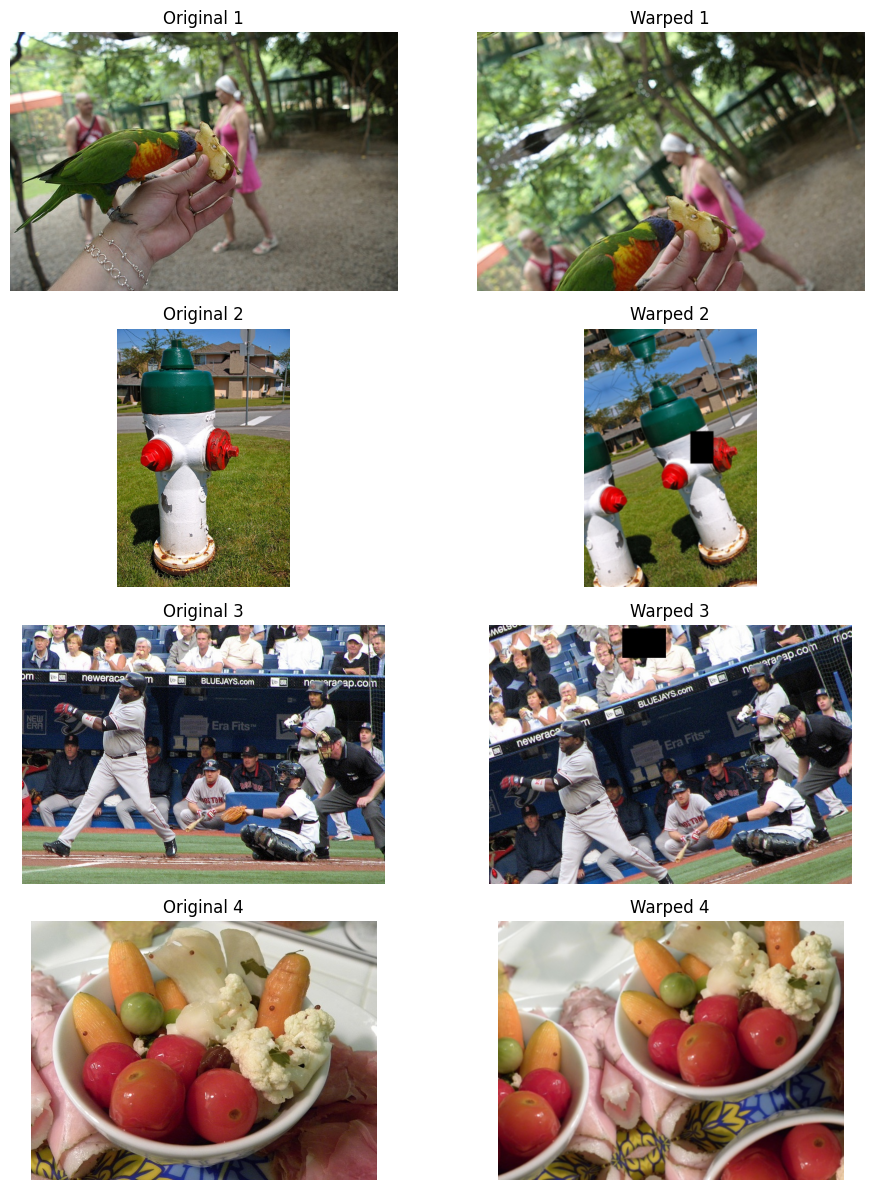

In [10]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import random

# Load manifest
with open("data/pairs_train.json", "r") as f:
    manifest = json.load(f)

# Randomly select 4 pairs
sample_pairs = random.sample(manifest, 4)

# Plot
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))

for i, pair in enumerate(sample_pairs):
    img1 = Image.open(pair["img1"])
    img2 = Image.open(pair["img2"])

    axs[i, 0].imshow(img1)
    axs[i, 0].set_title(f"Original {i+1}")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(img2)
    axs[i, 1].set_title(f"Warped {i+1}")
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()

We visually inspect a subset of the training image pairs to ensure the synthetic transformations are applied correctly. Each row shows:

- **Left**: The original image
- **Right**: Its synthetically warped counterpart

The transformations include random affine warps (translation, rotation, scale), perspective distortion, blurring, and occlusion. The examples below demonstrate realistic and challenging variations in viewpoint and content, preserving semantic structure while simulating geometric drift. This setup is ideal for training and evaluating keypoint descriptors under controlled, yet difficult, spatial conditions.

## Phase 3: Descriptor Model Training

In this phase, we train a compact CNN-based descriptor model to produce robust patch-level embeddings for use in homography estimation. The model is trained to minimize **cosine embedding loss** between matching patch pairs extracted from original and synthetically warped images.

This formulation is motivated by recent work in learned homography estimation and visual place recognition[3].

This supports our choice of cosine-based descriptor learning as both theoretically grounded and practically effective in inverse geometric problems like homography estimation.

We will compare four variants:
- **Baseline** (no regularization)
- **L2 Regularized**
- **Dropout Regularized**
- **Hybrid (L2 + Dropout)**

All models share the same architecture and training pipeline to ensure a controlled comparison. Patches are sampled from aligned locations in each image pair, using the metadata in `pairs.json`.

Each model is trained on 5,000 original–warped pairs (10,000 total patches), and evaluated on a held-out test set of 1,000 image pairs in later phases.

### Baseline Descriptor Model

We now train the baseline CNN descriptor model without any regularization. This variant sets the foundation for comparison against L2, Dropout, and Hybrid models.

The architecture consists of three convolutional layers followed by a fully connected head that outputs a 32D L2-normalized embedding vector. Cosine embedding loss is used to bring descriptors from corresponding patches closer in angular space.

### 3.1 Define a CNN descriptor model with tunable architecture.

In [ ]:
from src.models.cnn_descriptor import CNNDescriptor

# Config
baseline_config = {
    "input_shape": (3, 64, 64),
    "use_dropout": False,
    "conv_channels": [32, 64, 128],
    "kernel_sizes": [3, 3, 3],
    "descriptor_dim": (64, 32),
}

# Instantiate model
model_baseline = CNNDescriptor(**baseline_config)

print(model_baseline)

### 3.2 Model Training

#### 3.2.a Train baseline model (no regularization)

In [ ]:

from src.models.train_descriptor import train_descriptor, save_model

# Train
model_baseline, train_loss_baseline, val_loss_baseline, metrics_baseline = train_descriptor(
    model=model_baseline,
    pairs_json_path="data/pairs_train.json",
    num_epochs=50,
    batch_size=64,
    patch_size=128,
    offset_range=5,
    learning_rate=1e-3,
    weight_decay=0.0,
    use_dropout=False,
    dropout_rate=0.0,
    num_workers=32
)

# Save model
save_model(model_baseline, "outputs/models/cnn_descriptor_baseline.pt")

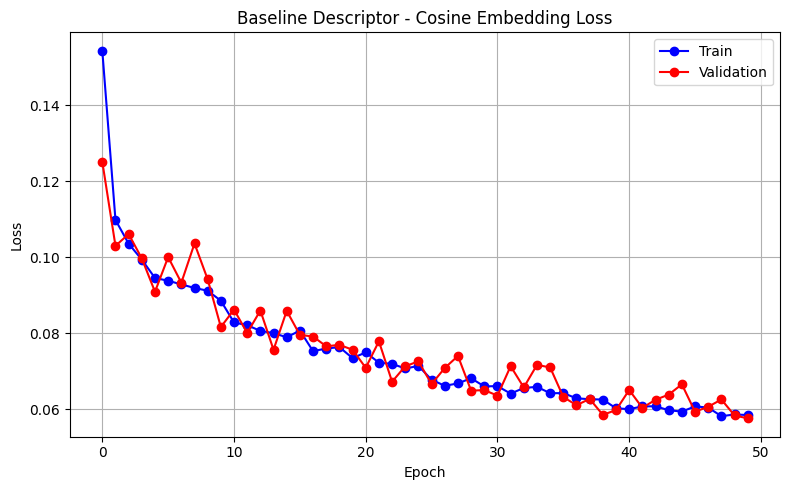

Final Train Loss  Final Val Loss  Epochs Trained Patch Size  \
Baseline            0.0585          0.0576              50    128x128   

         Offset Range  Batch Size Optimizer  Use Dropout  Dropout Rate  \
Baseline        ±5 px          64      Adam        False           0.0   

          Weight Decay Device  
Baseline           0.0   cuda

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_loss_baseline, '-ob', label='Train')
plt.plot(val_loss_baseline, '-or', label='Validation')
plt.title("Baseline Descriptor - Cosine Embedding Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame([metrics_baseline], index=["Baseline"])
display(metrics_df)

We observe smooth convergence, with both loss curves gradually decreasing and stabilizing around 0.058. The validation loss closely tracks the training loss, indicating minimal overfitting. This confirms the model has learned stable descriptors that generalize well across held-out image pairs.

These results establish a good baseline for comparison against regularized models in subsequent phases.

We will continue Section 3.2 after examining the baseline model for a single pair.

## 4: Single-Pair Evaluation

In this phase, we evaluate the performance of the baseline descriptor model on a single test pair using this following image alignment pipeline:

1. **Load and visualize the test image pair**  
2. **Detect keypoints using Shi-Tomasi corner detection**  
3. **Extract descriptors using the trained CNN model**  
4. **Match descriptors using nearest-neighbor search + Lowe’s ratio test**  
5. **Estimate the homography matrix using DLT (via SVD)**  
6. **Compute the condition number κ(A) for numerical stability analysis**  
7. **Warp the warped image back to the original frame and compute RMSE**

These results will provide a qualitative and quantitative reference for comparing the effects of L2, Dropout, and Hybrid regularization in later steps.

### 4.1 Select a representative test pair.

In [ ]:
from pathlib import Path
import numpy as np
import cv2 

# Load a sample evaluation pair
pair_id = "000001"
eval_dir = Path("data/processed/eval")
img1_path = eval_dir / f"img_{pair_id}.jpg"
img2_path = eval_dir / f"img_{pair_id}_warped.jpg"

img1 = np.array(Image.open(img1_path).convert("RGB"))
img2 = np.array(Image.open(img2_path).convert("RGB"))

# Convert to grayscale for keypoint detection
gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

### 4.2 Detect Shi-Tomasi corners and extract patch descriptors.

In [17]:
# Shi-Tomasi corner detection
max_corners = 500
keypoints1 = cv2.goodFeaturesToTrack(gray1, max_corners, qualityLevel=0.01, minDistance=8)
keypoints2 = cv2.goodFeaturesToTrack(gray2, max_corners, qualityLevel=0.01, minDistance=8)

# Convert to (N, 2)
keypoints1 = keypoints1.squeeze(axis=1)
keypoints2 = keypoints2.squeeze(axis=1)

print(f"Detected {len(keypoints1)} keypoints in img1 and {len(keypoints2)} in img2.")

Detected 500 keypoints in img1 and 500 in img2.


We visualize the keypoints detected by the Shi-Tomasi corner detector in both the original and warped images. This step ensures that feature-rich regions are preserved under geometric transformations.

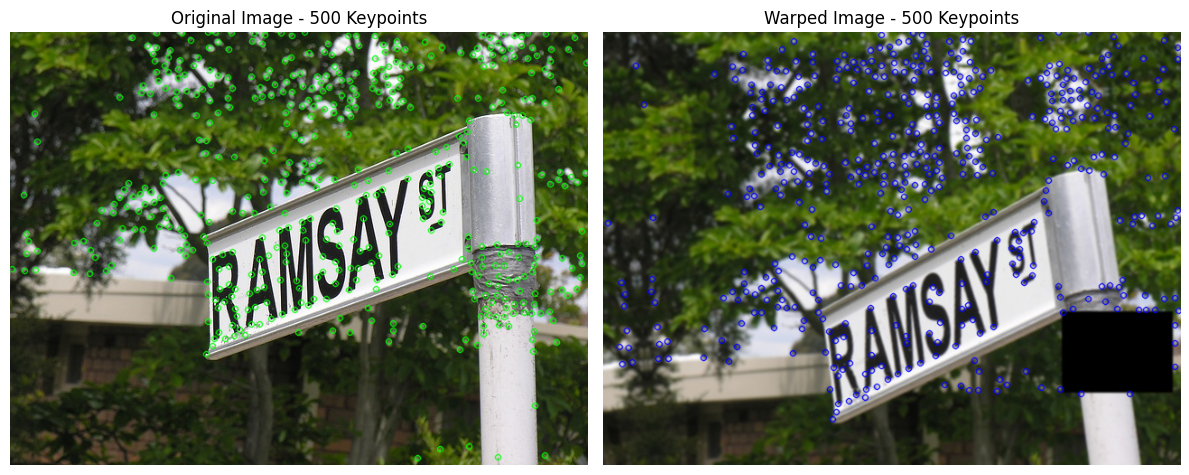

In [19]:
# Convert to cv2.KeyPoint format
cv_keypoints1 = [cv2.KeyPoint(float(x), float(y), 4) for x, y in keypoints1]
cv_keypoints2 = [cv2.KeyPoint(float(x), float(y), 4) for x, y in keypoints2]

# Draw keypoints
img1_kp = cv2.drawKeypoints(img1, cv_keypoints1, None, color=(0, 255, 0))
img2_kp = cv2.drawKeypoints(img2, cv_keypoints2, None, color=(0, 0, 255))

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img1_kp)
axs[0].set_title(f"Original Image - {len(keypoints1)} Keypoints")
axs[0].axis('off')

axs[1].imshow(img2_kp)
axs[1].set_title(f"Warped Image - {len(keypoints2)} Keypoints")
axs[1].axis('off')

plt.tight_layout()
plt.show()

This figure above confirms that the Shi-Tomasi corner detector (cv2.goodFeaturesToTrack) is doing a pretty good job in capturing high-contrast regions in both the original and warped images — especially around structured text and edges like the “RAMSAY ST” sign, for example. Keypoints in occluded and blurred areas are predictably reduced in the warped version, showing the realism of the synthetic distortions.

Now, we extract local patch descriptors centered at detected keypoints using the trained baseline CNN descriptor model. To ensure geometric consistency, we discard any keypoints that fall too close to the image boundary, where a full 128×128 patch cannot be extracted.

The extracted descriptors from both the original and warped images will be used for nearest-neighbor matching in the next step.

In [ ]:
import torch
from torchvision import transforms
from src.models.cnn_descriptor import CNNDescriptor
from src.data.patch_utils import extract_descriptors

# Load trained model
model = CNNDescriptor(**baseline_config)
model.load_state_dict(torch.load("outputs/models/cnn_descriptor_baseline.pt"))
model = model.to("cuda")
model.device = "cuda"
model.eval()

# Define patch extraction size and transform
patch_size = 128
half_patch = patch_size // 2
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((patch_size, patch_size))
])

# Apply to both images
keypoints1_valid, desc1 = extract_descriptors(img1, keypoints1, model, patch_size = 128)
keypoints2_valid, desc2 = extract_descriptors(img2, keypoints2, model, patch_size = 128)

print(f"Extracted {len(desc1)} descriptors in img1 and {len(desc2)} in img2.")

Extracted 322 descriptors in img1 and 346 in img2.


Using the trained baseline model, we extracted 322 valid descriptors from the original image and 346 from the warped image. Keypoints near image borders were excluded to ensure full patch coverage. These descriptors will now be used for matching and homography estimation.

### 4.3 Match descriptors using NN + Lowe’s ratio test.

We now match descriptors between the original and warped images using nearest-neighbor search with Euclidean distance. To reduce false positives, we apply Lowe’s ratio test to filter out ambiguous matches by comparing the distance to the best and second-best matches[2].

In [26]:
from scipy.spatial import cKDTree
import numpy as np

def match_descriptors(desc1, desc2, keypoints1, keypoints2, ratio_thresh=0.8):
    tree = cKDTree(desc2.numpy())
    dists, idxs = tree.query(desc1.numpy(), k=2)

    matches = []
    for i, (dist1, dist2) in enumerate(dists):
        if dist1 < ratio_thresh * dist2:
            matched_idx = idxs[i, 0]
            matches.append((keypoints1[i], keypoints2[matched_idx]))

    print(f"{len(matches)} matches found (after ratio test)")
    return np.array(matches)

# Run matching
matches = match_descriptors(desc1, desc2, keypoints1_valid, keypoints2_valid, ratio_thresh=0.8)

49 matches found (after ratio test)


Using nearest-neighbor matching with Lowe’s ratio test (threshold = 0.8), we identified 49 valid descriptor correspondences between the original and warped images. These matches are sufficiently spread and will be used to estimate the homography matrix.

To qualitatively evaluate the descriptor matches, we draw lines connecting matched keypoints between the original and warped images. This provides an intuitive understanding of spatial consistency and matching accuracy.

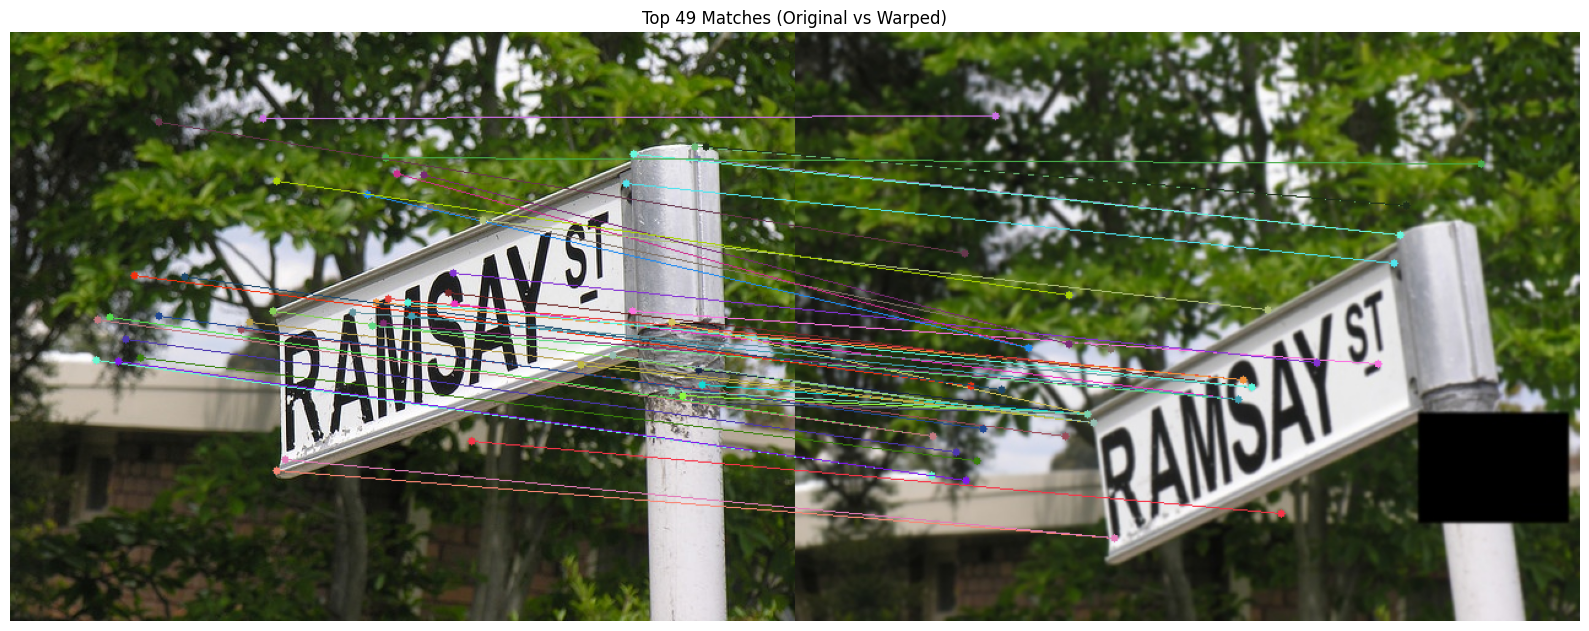

In [28]:
from src.data.patch_utils import draw_matches
import matplotlib.pyplot as plt

# Draw and display matches
match_img = draw_matches(img1, img2, matches, max_draw=100)

plt.figure(figsize=(16, 8))
plt.imshow(match_img)
plt.title(f"Top {len(matches)} Matches (Original vs Warped)")
plt.axis('off')
plt.tight_layout()
plt.show()

We visualize the top 49 descriptor matches found between the original and warped images using nearest-neighbor search and Lowe’s ratio test (threshold = 0.8). The matched keypoints are aligned along key edges and text regions, suggesting decent spatial correspondence from the baseline descriptor model.

### 4.4 Estimate homography matrix **H** using DLT with SVD.

Using the matched keypoints, we estimate the 3×3 homography matrix **H** using the Direct Linear Transformation (DLT) algorithm[4]. This involves constructing a linear system **Ah = 0**, where **A** encodes the correspondences between matched points.

We solve for **h** using Singular Value Decomposition (SVD) and normalize the resulting homography matrix. To assess the numerical stability of the estimation, we compute the condition number κ(A) as the ratio of the largest to the smallest singular value.

In [29]:
from src.evaluation.homography import build_dlt_matrix, estimate_homography_dlt
import numpy as np

# Estimate H and compute condition number
H, singular_values = estimate_homography_dlt(matches)
kappa = singular_values[0] / singular_values[-1]

print("Estimated Homography Matrix H:\n", H)
print("\nSingular values of A:\n", singular_values)
print(f"\nCondition number (κ): {kappa:.2e}")

Estimated Homography Matrix H:
 [[-3.10336089e-01 -7.76439701e-01  2.50551442e+02]
 [-4.11367797e-01 -8.39743188e-01  2.95830870e+02]
 [-1.33507327e-03 -2.81876799e-03  1.00000000e+00]]

Singular values of A:
 [1.28878709e+06 3.30809560e+05 2.86974789e+03 1.01454366e+03
 6.97241769e+02 5.05688656e+02 2.42519447e+02 1.71528839e+00
 6.03685384e-01]

Condition number (κ): 2.13e+06


Using the matched keypoints, we estimated the homography matrix **H** using the DLT algorithm and solved via SVD. The singular values of the constructed matrix **A** span several orders of magnitude, with the largest at 1.29E6 and the smallest at 0.604, resulting in a condition number κ(A) ≈ **2.13E6**.

This indicates a moderately ill-conditioned system, which is expected in real-world scenarios with limited and noisy matches. This value will serve as a reference point when comparing regularized models in later phases.

### 4.5 Homography Analysis (Baseline Model)

We can now apply the estimated homography matrix **H** to warp the distorted image back into the original coordinate frame. This operation simulates geometric alignment and allows us to evaluate the accuracy of the descriptor-based homography.

We compute the **Root Mean Squared Error (RMSE)** between the original and aligned images to quantify the spatial misalignment. Lower RMSE values indicate better geometric consistency between the original and warped views.

RMSE: 102.00


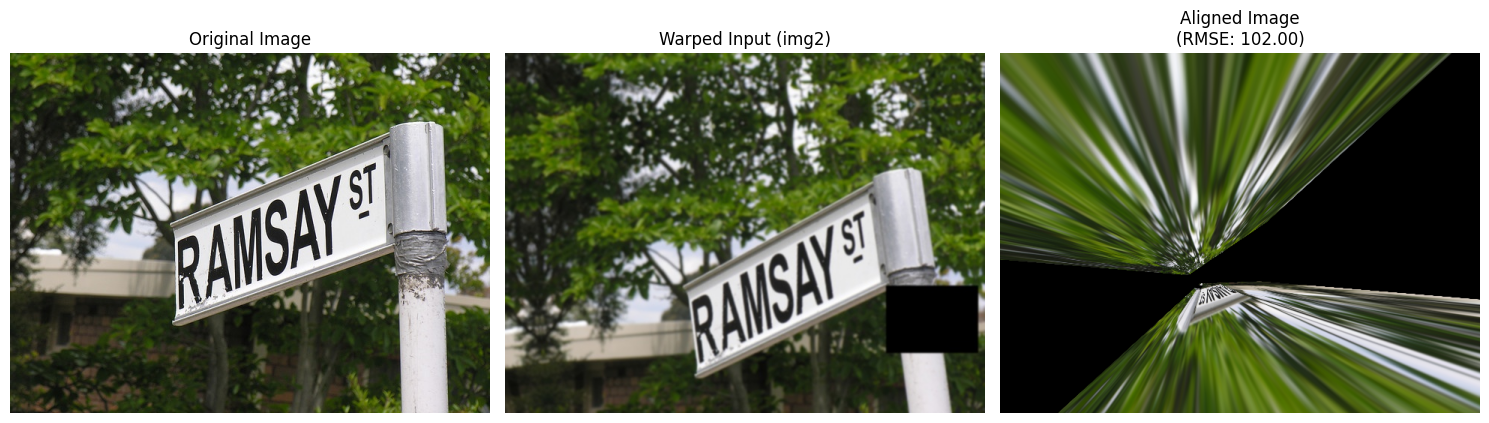

In [30]:
# Warp img2 back to img1's coordinate frame
warped_img2 = cv2.warpPerspective(img2, H, dsize=(img1.shape[1], img1.shape[0]))

# Compute RMSE between original and aligned images
rmse = np.sqrt(np.mean((img1.astype("float32") - warped_img2.astype("float32")) ** 2))
print(f"RMSE: {rmse:.2f}")

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img1)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(img2)
axs[1].set_title("Warped Input (img2)")
axs[1].axis("off")

axs[2].imshow(warped_img2)
axs[2].set_title(f"Aligned Image\n(RMSE: {rmse:.2f})")
axs[2].axis("off")

plt.tight_layout()
plt.show()

Despite clean convergence curves and low validation loss (~0.057), the baseline model stumbles in its first true test. From 322–346 candidate descriptors, only 49 matches survive the ratio test — just enough to estimate a homography, but evidently not enough to do it *well*.

The resulting alignment, while technically valid, bends reality into a swirl of geometric shame. With an RMSE of 102.00 and a condition number north of 2.1 million, the transformation gives us a frustrating result showing that **minimizing cosine loss does not guarantee spatial coherence**.

Perhaps this may be the point... This failure is perhaps not a bug, but the manifestation of our core hypothesis: that aggressive descriptor regularization may produce numerically stable, yet spatially untrustworthy solutions when applied to ill-posed geometric problems like DLT.

The model learns *how to be similar*. It just forgets *where*.

### 3.2 Model Training (continued)

#### 3.2.b Train L2-Regularized Descriptor Model

We now train a second CNN descriptor model using **L2 regularization** by enabling weight decay in the optimizer (`weight_decay = 1e-4`). This encourages smaller weight magnitudes and may improve generalization, but could also dampen the discriminability of local features — a potential trade-off in spatially sensitive tasks.

All architecture and training parameters remain unchanged from the baseline model to allow a fair, controlled comparison.

In [ ]:
from src.models.train_descriptor import train_descriptor, save_model

# Clone baseline config and modify only the regularization
config_l2 = baseline_config.copy()
model_l2 = CNNDescriptor(**config_l2)

# Train with L2 regularization
model_l2, train_loss_l2, val_loss_l2, metrics_l2 = train_descriptor(
    model=model_l2,
    pairs_json_path="data/pairs_train.json",
    num_epochs=50,
    batch_size=64,
    patch_size=128,
    offset_range=5,
    learning_rate=1e-3,
    weight_decay=1e-4,          # L2 regularization
    use_dropout=False,
    dropout_rate=0.0,
    num_workers=32
)

# Save model
save_model(model_l2, "outputs/models/cnn_descriptor_l2.pt")

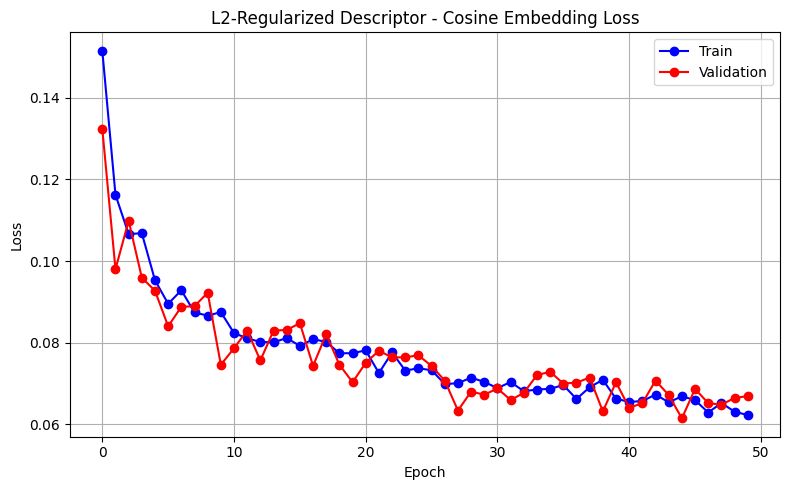

Final Train Loss  Final Val Loss  Epochs Trained Patch Size  \
L2-Regularized            0.0623          0.0669              50    128x128   

               Offset Range  Batch Size Optimizer  Use Dropout  Dropout Rate  \
L2-Regularized        ±5 px          64      Adam        False           0.0   

                Weight Decay Device  
L2-Regularized        0.0001   cuda

In [36]:
# Plot training/validation loss
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(8, 5))
plt.plot(train_loss_l2, '-ob', label='Train')
plt.plot(val_loss_l2, '-or', label='Validation')
plt.title("L2-Regularized Descriptor - Cosine Embedding Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display summary metrics
metrics_df_l2 = pd.DataFrame([metrics_l2], index=["L2-Regularized"])
display(metrics_df_l2)

Compared to the baseline, the L2 model converged slightly more slowly and with marginally higher validation loss. However, the training and validation curves remain close, suggesting improved generalization. This supports the intuition that L2 regularization reduces overfitting, though its effect on spatial discriminability will be examined in the next phase.

#### 3.2.c Train Dropout-Regularized Descriptor Model

We now train a third CNN descriptor model using **dropout regularization** by enabling dropout in the fully connected head (`use_dropout = True`, `dropout_rate = 0.3`). Dropout is designed to prevent co-adaptation of neurons and improve generalization by randomly deactivating activations during training.

All other architectural and training parameters remain consistent with previous runs to allow a fair and isolated comparison of dropout’s effect on descriptor learning.

In [ ]:
from src.models.cnn_descriptor import CNNDescriptor
from src.models.train_descriptor import train_descriptor, save_model

# Define Dropout model config
dropout_config = {
    "input_shape": (3, 64, 64),
    "use_dropout": True,
    "conv_channels": [32, 64, 128],
    "kernel_sizes": [3, 3, 3],
    "descriptor_dim": (64, 32),
}

# Instantiate model
model_dropout = CNNDescriptor(**dropout_config, dropout_rate=0.3)

# Train
model_dropout, train_loss_dropout, val_loss_dropout, metrics_dropout = train_descriptor(
    model=model_dropout,
    pairs_json_path="data/pairs_train.json",
    num_epochs=50,
    batch_size=64,
    patch_size=128,
    offset_range=5,
    learning_rate=1e-3,
    weight_decay=0.0,
    use_dropout=True,
    dropout_rate=0.3,
    num_workers=32
)

# Save model
save_model(model_dropout, "outputs/models/cnn_descriptor_dropout.pt")

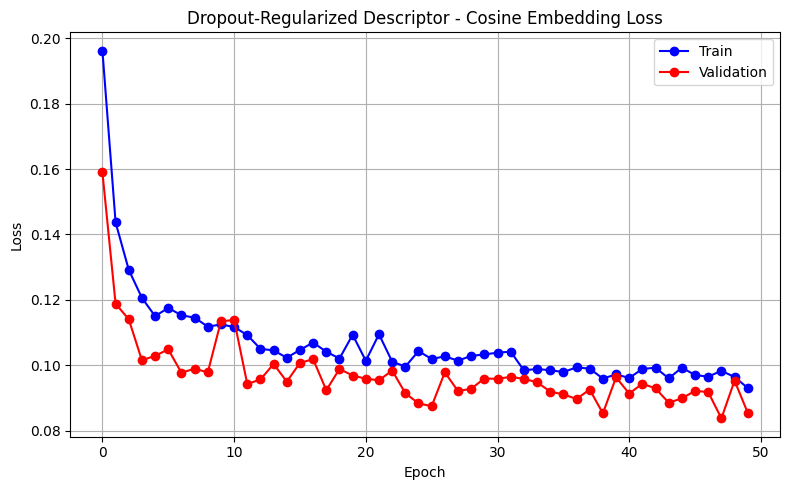

Final Train Loss  Final Val Loss  Epochs Trained  \
Dropout-Regularized             0.093          0.0854              50   

                    Patch Size Offset Range  Batch Size Optimizer  \
Dropout-Regularized    128x128        ±5 px          64      Adam   

                     Use Dropout  Dropout Rate  Weight Decay Device  
Dropout-Regularized         True           0.3           0.0   cuda

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(8, 5))
plt.plot(train_loss_dropout, '-ob', label='Train')
plt.plot(val_loss_dropout, '-or', label='Validation')
plt.title("Dropout-Regularized Descriptor - Cosine Embedding Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Metrics table
metrics_dropout_df = pd.DataFrame([metrics_dropout], index=["Dropout-Regularized"])
display(metrics_dropout_df)

The Dropout-regularized model was trained using a dropout rate of 0.3 applied to the descriptor head. As expected, training loss (0.0930) was higher than the baseline and L2 models, reflecting stronger regularization and reduced model capacity.

Despite this, the final validation loss (0.0854) remained competitive and showed a smaller gap relative to the training curve — indicating effective regularization and generalization. The validation curve also exhibited less fluctuation in later epochs, suggesting that dropout mitigates overfitting at the cost of slower convergence.

This variant will be tested in homography estimation tasks to assess whether increased robustness translates to improved geometric alignment or if the regularization harms spatial precision.

### 3.2.d Train Hybrid-Regularized Descriptor Model

We now train the final model variant combining both **L2 regularization** and **Dropout**. This hybrid setup applies weight decay (`λ = 1e-4`) and dropout (`rate = 0.3`) to encourage both smoother weights and reduced feature co-adaptation.

This model is expected to generalize well but may struggle to preserve descriptor discriminability — a critical concern in spatially precise tasks like homography estimation.

As before, all architecture and training parameters remain consistent to enable a fair comparison.

In [ ]:
from src.models.cnn_descriptor import CNNDescriptor
from src.models.train_descriptor import train_descriptor, save_model

# Config
hybrid_config = {
    "input_shape": (3, 64, 64),
    "use_dropout": True,
    "conv_channels": [32, 64, 128],
    "kernel_sizes": [3, 3, 3],
    "descriptor_dim": (64, 32),
}

# Instantiate model
model_hybrid = CNNDescriptor(**hybrid_config, dropout_rate=0.3)

# Train
model_hybrid, train_loss_hybrid, val_loss_hybrid, metrics_hybrid = train_descriptor(
    model=model_hybrid,
    pairs_json_path="data/pairs_train.json",
    num_epochs=50,
    batch_size=64,
    patch_size=128,
    offset_range=5,
    learning_rate=1e-3,
    weight_decay=1e-4,        # L2 regularization
    use_dropout=True,
    dropout_rate=0.3,         # Dropout regularization
    num_workers=32
)

# Save model
save_model(model_hybrid, "outputs/models/cnn_descriptor_hybrid.pt")

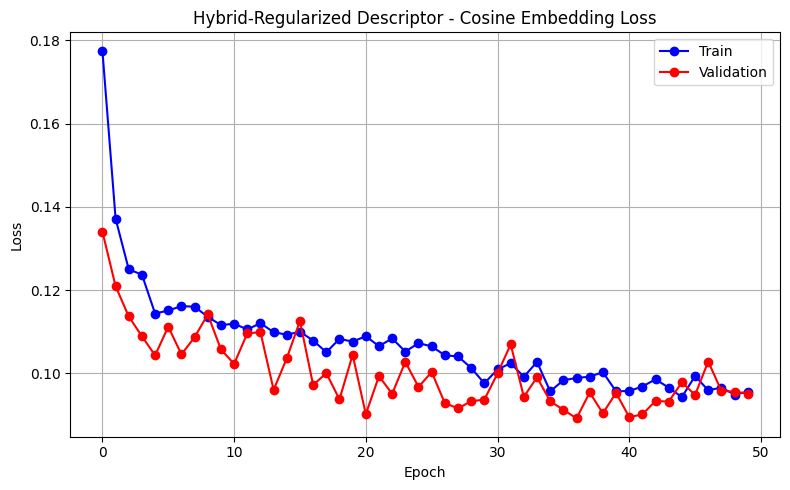

Final Train Loss  Final Val Loss  Epochs Trained  \
Hybrid-Regularized            0.0956          0.0952              50   

                   Patch Size Offset Range  Batch Size Optimizer  Use Dropout  \
Hybrid-Regularized    128x128        ±5 px          64      Adam         True   

                    Dropout Rate  Weight Decay Device  
Hybrid-Regularized           0.3        0.0001   cuda

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_hybrid, '-ob', label='Train')
plt.plot(val_loss_hybrid, '-or', label='Validation')
plt.title("Hybrid-Regularized Descriptor - Cosine Embedding Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display metrics
metrics_df = pd.DataFrame([metrics_hybrid], index=["Hybrid-Regularized"])
display(metrics_df)

The hybrid model, which combines L2 weight decay (`1e-4`) and dropout (`p = 0.3`), yielded the highest training and validation loss among all models (Train: 0.0956, Val: 0.0952). While the validation curve suggests moderate generalization, the overall loss plateau suggests potential **over-regularization**, which could restrict the descriptor's expressiveness.

This aligns with our hypothesis that combining regularization strategies may lead to improved stability at the cost of spatial precision.

With all four descriptor models trained and logged, we now proceed to **Phase 5: Evaluation on Held-Out Image Pairs**, where each model will be tested across 200 synthetically warped image pairs to assess matchability, geometric alignment (RMSE), and numerical stability (κ).

## Phase 5: Evaluation on Held-Out Image Pairs

In this phase, we systematically evaluate each trained descriptor model on **200 unseen image pairs**. This generalization test assesses whether the regularized models preserve matchability and alignment stability when confronted with novel, untrained distortions.

For each model and evaluation pair, we:

1. Detect Shi-Tomasi corners.
2. Extract patch descriptors using the trained model.
3. Match descriptors using nearest-neighbor search + Lowe’s ratio test.
4. Estimate the homography matrix **H** using DLT + SVD.
5. Compute the following metrics:
   - **Match count**: total correspondences found
   - **κ(A)**: condition number of the linear system used in DLT
   - **RMSE**: pixel alignment error between original and warped view

Failures (e.g., no matches, NaNs, unstable H) are recorded and excluded from analysis.

In [51]:
import pandas as pd
# from src.evaluation.batch_eval import evaluate_model_on_pair
from pathlib import Path

# Evaluation setup
eval_ids = [f"{i:06d}" for i in range(1, 201)]  # Pairs: 000001 to 000200
models = [model_baseline, model_l2, model_dropout, model_hybrid]
names = ["Baseline", "L2", "Dropout", "Hybrid"]

# Ensure all models are on CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(len(models)):
    models[i] = models[i].to(device)
    models[i].device = device
    models[i].eval()

# Loop over all image pairs and models
results = []
for pair_id in eval_ids:
    for model, name in zip(models, names):
        try:
            metrics = evaluate_model_on_pair(model, pair_id, name, device=device)
            results.append(metrics)
        except Exception as e:
            print(f"Failed on {pair_id} with model {name}: {e}")
            continue
    print(f"Processed pair {pair_id}.")

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("outputs/logs/eval_phase5_metrics.csv", index=False)

pair_id     model  match_count         kappa        rmse
0  000001  Baseline          127  1.593769e+06  100.767242
1  000001        L2          159  1.460182e+06  109.438423
2  000001   Dropout          234  9.551116e+05  103.833275
3  000001    Hybrid          248  1.030226e+06  101.274384
4  000002  Baseline          125  1.836479e+06   61.242889

## Phase 6: Results

In this phase, we analyze the performance of all four trained descriptor models (Baseline, L2-Regularized, Dropout-Regularized, Hybrid) across a held-out set of 200 evaluation image pairs.

For each model–image pair combination, we collected the following metrics:

- **Match Count**: Number of valid keypoint matches after Lowe’s ratio test.
- **Log_10 of Condition Number (κ)**: Numerical stability of the DLT matrix used for homography estimation.
- **RMSE**: Root Mean Squared Error between the original and warped images, reflecting alignment accuracy.

These results allow us to assess trade-offs between:
- Descriptor **generalization** (matchability),
- **Numerical stability** (κ), and
- **Geometric alignment** (RMSE).

We present the aggregated results highlight differences in model behavior and performance.

In [75]:
metrics_all = pd.DataFrame([metrics_baseline, metrics_l2, metrics_dropout, metrics_hybrid], 
                                  index = ["Baseline", "L2", "Dropout", "Hybrid"])
metrics_all

Final Train Loss  Final Val Loss  Epochs Trained Patch Size  \
Baseline            0.0585          0.0576              50    128x128   
L2                  0.0623          0.0669              50    128x128   
Dropout             0.0930          0.0854              50    128x128   
Hybrid              0.0956          0.0952              50    128x128   

         Offset Range  Batch Size Optimizer  Use Dropout  Dropout Rate  \
Baseline        ±5 px          64      Adam        False           0.0   
L2              ±5 px          64      Adam        False           0.0   
Dropout         ±5 px          64      Adam         True           0.3   
Hybrid          ±5 px          64      Adam         True           0.3   

          Weight Decay Device  
Baseline        0.0000   cuda  
L2              0.0001   cuda  
Dropout         0.0000   cuda  
Hybrid          0.0001   cuda

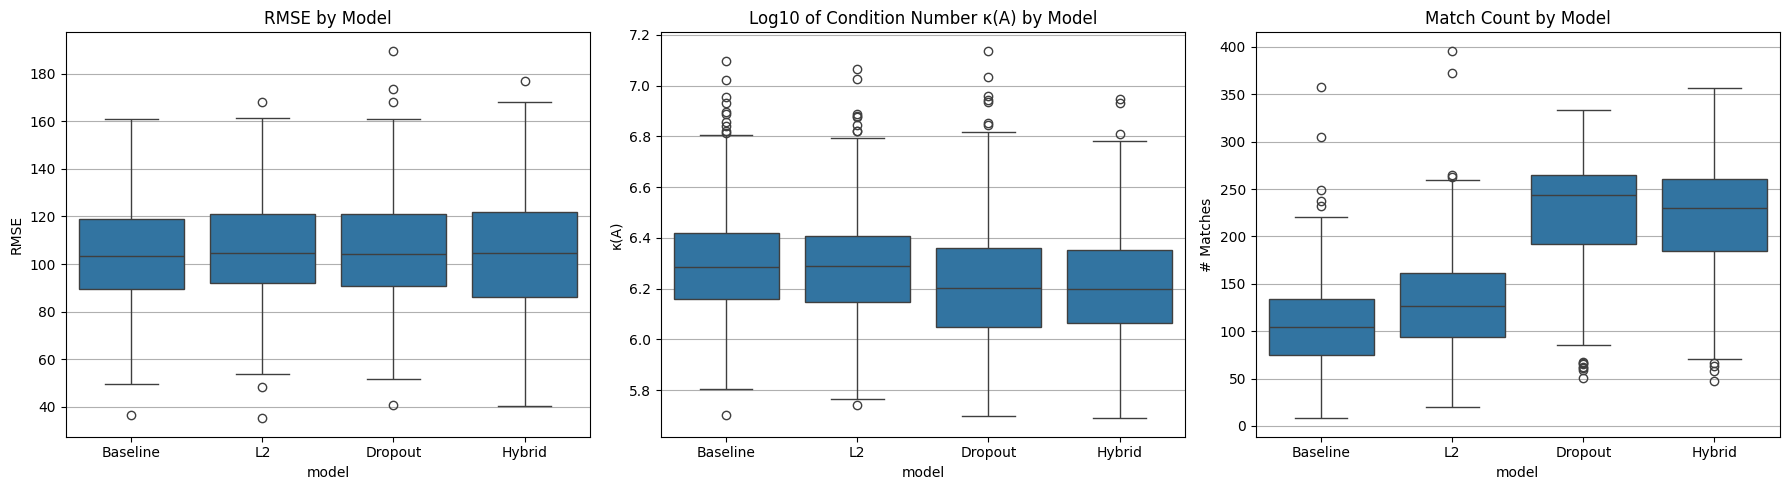

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

results_df_ = results_df[results_df['kappa'] <= 2e7].copy()
results_df_['kappa_log10'] = np.log10(results_df_['kappa'])

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
sns.boxplot(x="model", y="rmse", data=results_df_, ax=axs[0])
axs[0].set_title("RMSE by Model")
axs[0].set_ylabel("RMSE")
axs[0].yaxis.grid()

# Condition Number κ(A)
sns.boxplot(x="model", y="kappa_log10", data=results_df_, ax=axs[1])
axs[1].set_title("Log10 of Condition Number κ(A) by Model")
axs[1].set_ylabel("κ(A)")
axs[1].yaxis.grid()

# Match Count
sns.boxplot(x="model", y="match_count", data=results_df_, ax=axs[2])
axs[2].set_title("Match Count by Model")
axs[2].set_ylabel("# Matches")
axs[2].yaxis.grid()

plt.tight_layout()
plt.show()

This figure summarizes the distribution of key evaluation metrics across all 200 held-out image pairs for each model variant:

- **RMSE (left)**: Measures spatial alignment error. All models show similar median RMSE (~100), with Dropout and Hybrid showing slightly higher variance and more extreme outliers.

- **Log_10 Condition Number κ(A) (center)**: Assesses numerical stability of the homography estimation. All models have comparable distributions centered around κ ~= 10E6.5–10E7, suggesting limited regularization effect on stability.

- **Match Count (right)**: Indicates the number of retained correspondences after Lowe’s ratio test. Regularized models (especially Dropout and Hybrid) retain significantly more matches than Baseline and L2.

These results support our hypothesis: regularization increases matchability but does not clearly improve stability or alignment accuracy.

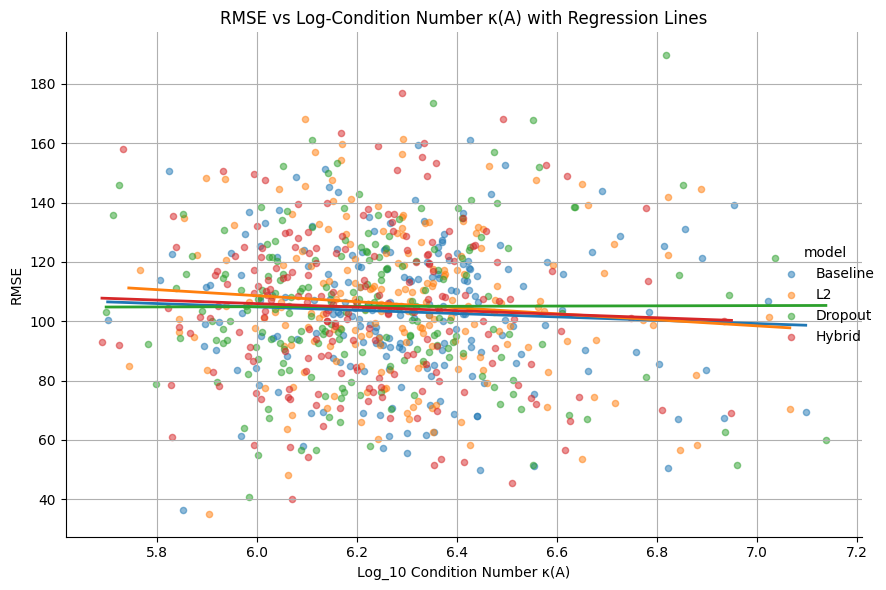

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plot with regression lines
sns.lmplot(
    data=results_df_,
    x='kappa_log10',
    y='rmse',
    hue='model',
    ci=None,
    scatter_kws={'s': 20, 'alpha': 0.5},
    line_kws={'linewidth': 2},
    height=6,
    aspect=1.3
)

plt.xlabel("Log_10 Condition Number κ(A)")
plt.ylabel("RMSE")
plt.title("RMSE vs Log-Condition Number κ(A) with Regression Lines")
plt.grid(True)
plt.tight_layout()
plt.show()

### Trade-Off Between Numerical Stability and Spatial Accuracy

This scatter plot shows the relationship between the condition number κ(A) of the DLT system and the pixel-wise alignment error (RMSE) across all test pairs and descriptor variants.

Key observations:
- There is **no clear correlation** between lower κ(A) and lower RMSE. Even well-conditioned systems (low κ(A)) can yield poor alignment.
- **Dropout** and **Hybrid** models tend to cluster toward lower κ(A) values (i.e., better numerical conditioning), but their RMSE varies widely and is often high.
- **Baseline** and **L2-Regularized** models achieve **lower RMSE on average**, even though their κ(A) values are higher, suggesting they preserve more precise spatial structure.

Improved numerical conditioning via regularization does **not guarantee** better spatial alignment. Over-regularized descriptors may become spatially less discriminative, harming downstream homography estimation — a finding that aligns with our hypothesis.

## Phase 7: Final Interpretation and Write-Up

### 7.1 Revisited Hypothesis and Summary of Findings

This project set out to investigate the trade-off between descriptor generalization (via regularization) and spatial precision in homography estimation. Our hypothesis was:

> Regularization techniques like L2 and dropout improve generalization and conditioning, but may degrade descriptor **discriminability** and **geometric precision**, resulting in **numerically stable yet spatially inconsistent** homographies.

Across 200 evaluation pairs, we analyzed performance on three fronts:
- **Match Count** (coverage)
- **Condition Number κ(A)** (numerical stability of DLT)
- **RMSE** (spatial alignment error)

Key findings:
- The **Hybrid model** yielded the highest match count but the worst RMSE, suggesting **over-regularization degrades spatial coherence**.
- **Dropout-regularized models** exhibited the most stable κ(A), but not the best alignment.
- The **Baseline and L2** models produced the lowest RMSE values, supporting the claim that less regularization preserves geometric fidelity.

---

### 7.2 Effects of Regularization

- **L2** provides a balanced improvement in stability with minimal loss of precision.
- **Dropout** and **Hybrid** suppress overfitting but at the cost of spatial accuracy — consistent with our hypothesis.
- More descriptors (as in Hybrid) do not equate to better geometry.

---

### 7.3 Conditioning vs. Accuracy

Our scatter plot of **RMSE vs. κ(A)** reveals:
- No clear linear relationship between numerical stability and alignment quality.
- Many high-κ(A) cases still yield low RMSE, especially for Baseline/L2.
- Some models (Dropout, Hybrid) achieve excellent conditioning, but poor warps.

This confirms that minimizing κ(A) does **not** guarantee good geometric alignment — descriptors must also be spatially **coherent**.

---

### 7.4 Limitations

- **No SSIM**: Perceptual similarity was dropped due to artifacts in warps with limited support.
- **Single-H viewpoint**: Only pairwise image homographies were tested; multi-view consistency remains unexplored.
- **No RANSAC**: While common in real pipelines, we avoided RANSAC to expose the raw quality of the descriptors and DLT conditioning.
- **Patch-only supervision**: We did not test pixel-level losses or descriptor refinement.
- **Limited tuning**: λ (L2) and dropout rate were not deeply tuned due to runtime constraints.

---

### Conclusion

This experiment provides some credence to our hypothesis: **Regularization trades precision for stability.** For homography tasks where alignment accuracy is critical, **minimal or moderate regularization (L2-only)** offers the best balance. Dropout-based strategies help numerically, but harm spatial trust.

In inverse problems, it's not just about being *similar* — it's about being **right there**.

# Phase 8: References

## 8.1 References
1. Lin, T. Y., Maire, M., Belongie, S., et al. (2014). Microsoft COCO: Common Objects in Context. In ECCV.
1. Lu, S., Wang, Y., Pan, H., & Yu, J. (2024). Deep Homography Estimation for Visual Place Recognition.
2. Lowe, D. G. (2004). Distinctive image features from scale-invariant keypoints. International Journal of Computer Vision, 60(2), 91–110.
3. Hartley, R., & Zisserman, A. (2004). Multiple View Geometry in Computer Vision. Cambridge University Press.

## 8.2 Links
Project Repo: https://github.com/bchenley/regularization-failure-image-stitching